# Node and Edge Embeddings - Using GNN

In [19]:
import pickle
import torch
import time
import random
import datetime
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from functions import AMLDataPreprocessing
from pandas import Timestamp
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling, train_test_split_edges

![Screenshot 2024-05-22 at 18.37.26.png](<attachment:Screenshot 2024-05-22 at 18.37.26.png>)
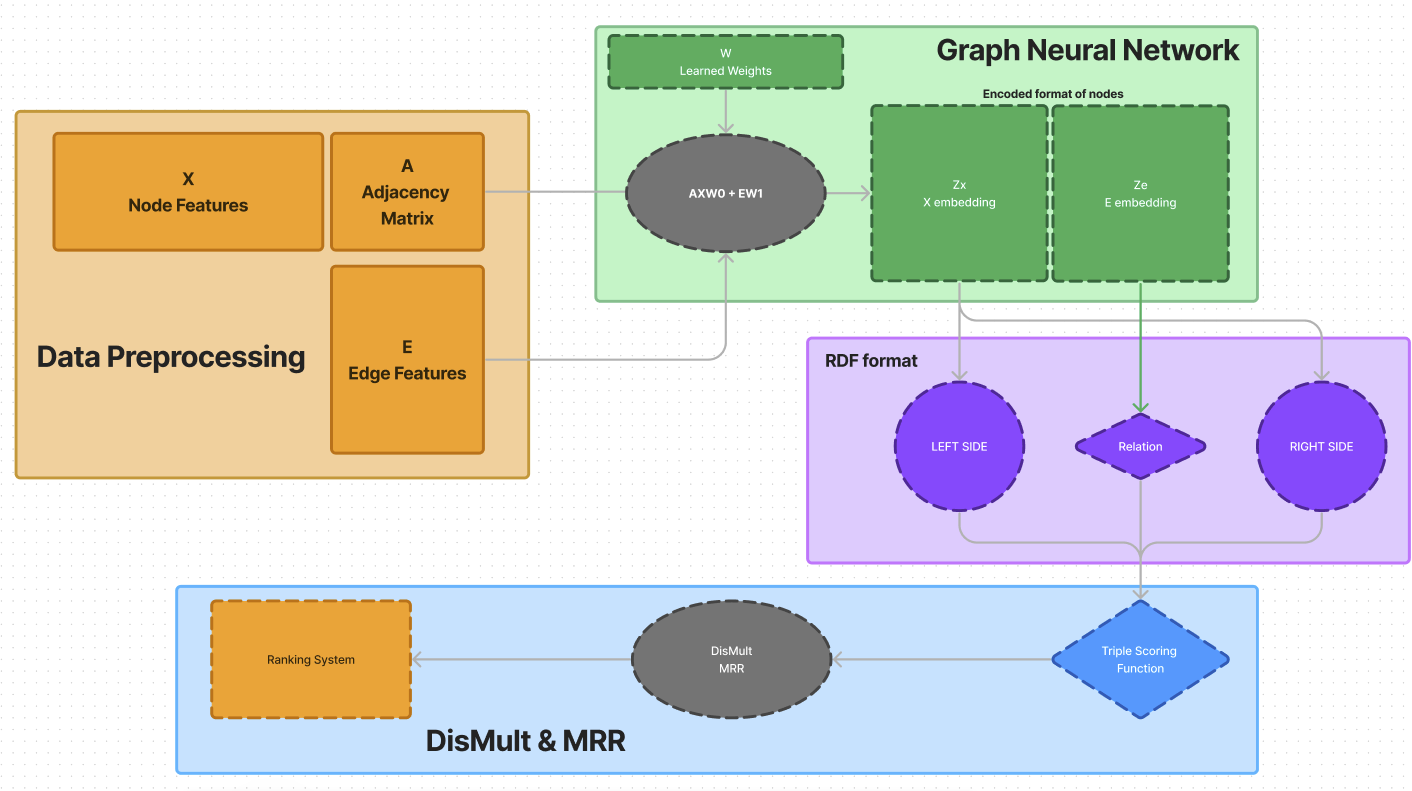

# LOADING GRAPH from Jupyter Notebook 
\(only use if not using Class Preprocessor)

# PROCESS DATA directly

Data Head - <bound method NDFrame.head of              Timestamp  From Bank    Account  To Bank  Account.1  \
0     2022/09/01 00:20         10  8000EBD30       10  8000EBD30   
1     2022/09/01 00:20       3208  8000F4580        1  8000F5340   
2     2022/09/01 00:00       3209  8000F4670     3209  8000F4670   
3     2022/09/01 00:02         12  8000F5030       12  8000F5030   
4     2022/09/01 00:06         10  8000F5200       10  8000F5200   
...                ...        ...        ...      ...        ...   
4994  2022/09/01 00:15      11318  80087D580    11318  80087D580   
4995  2022/09/01 00:02       1674  80087D1B0     1674  80087D1B0   
4996  2022/09/01 00:19        220  80087EA60      220  80087EA60   
4997  2022/09/01 00:19       2843  8008789D0     2843  8008789D0   
4998  2022/09/01 00:29       1674  80087AC10     1674  80087AC10   

      Amount Received Receiving Currency  Amount Paid Payment Currency  \
0             3697.34          US Dollar      3697.34        US Dol

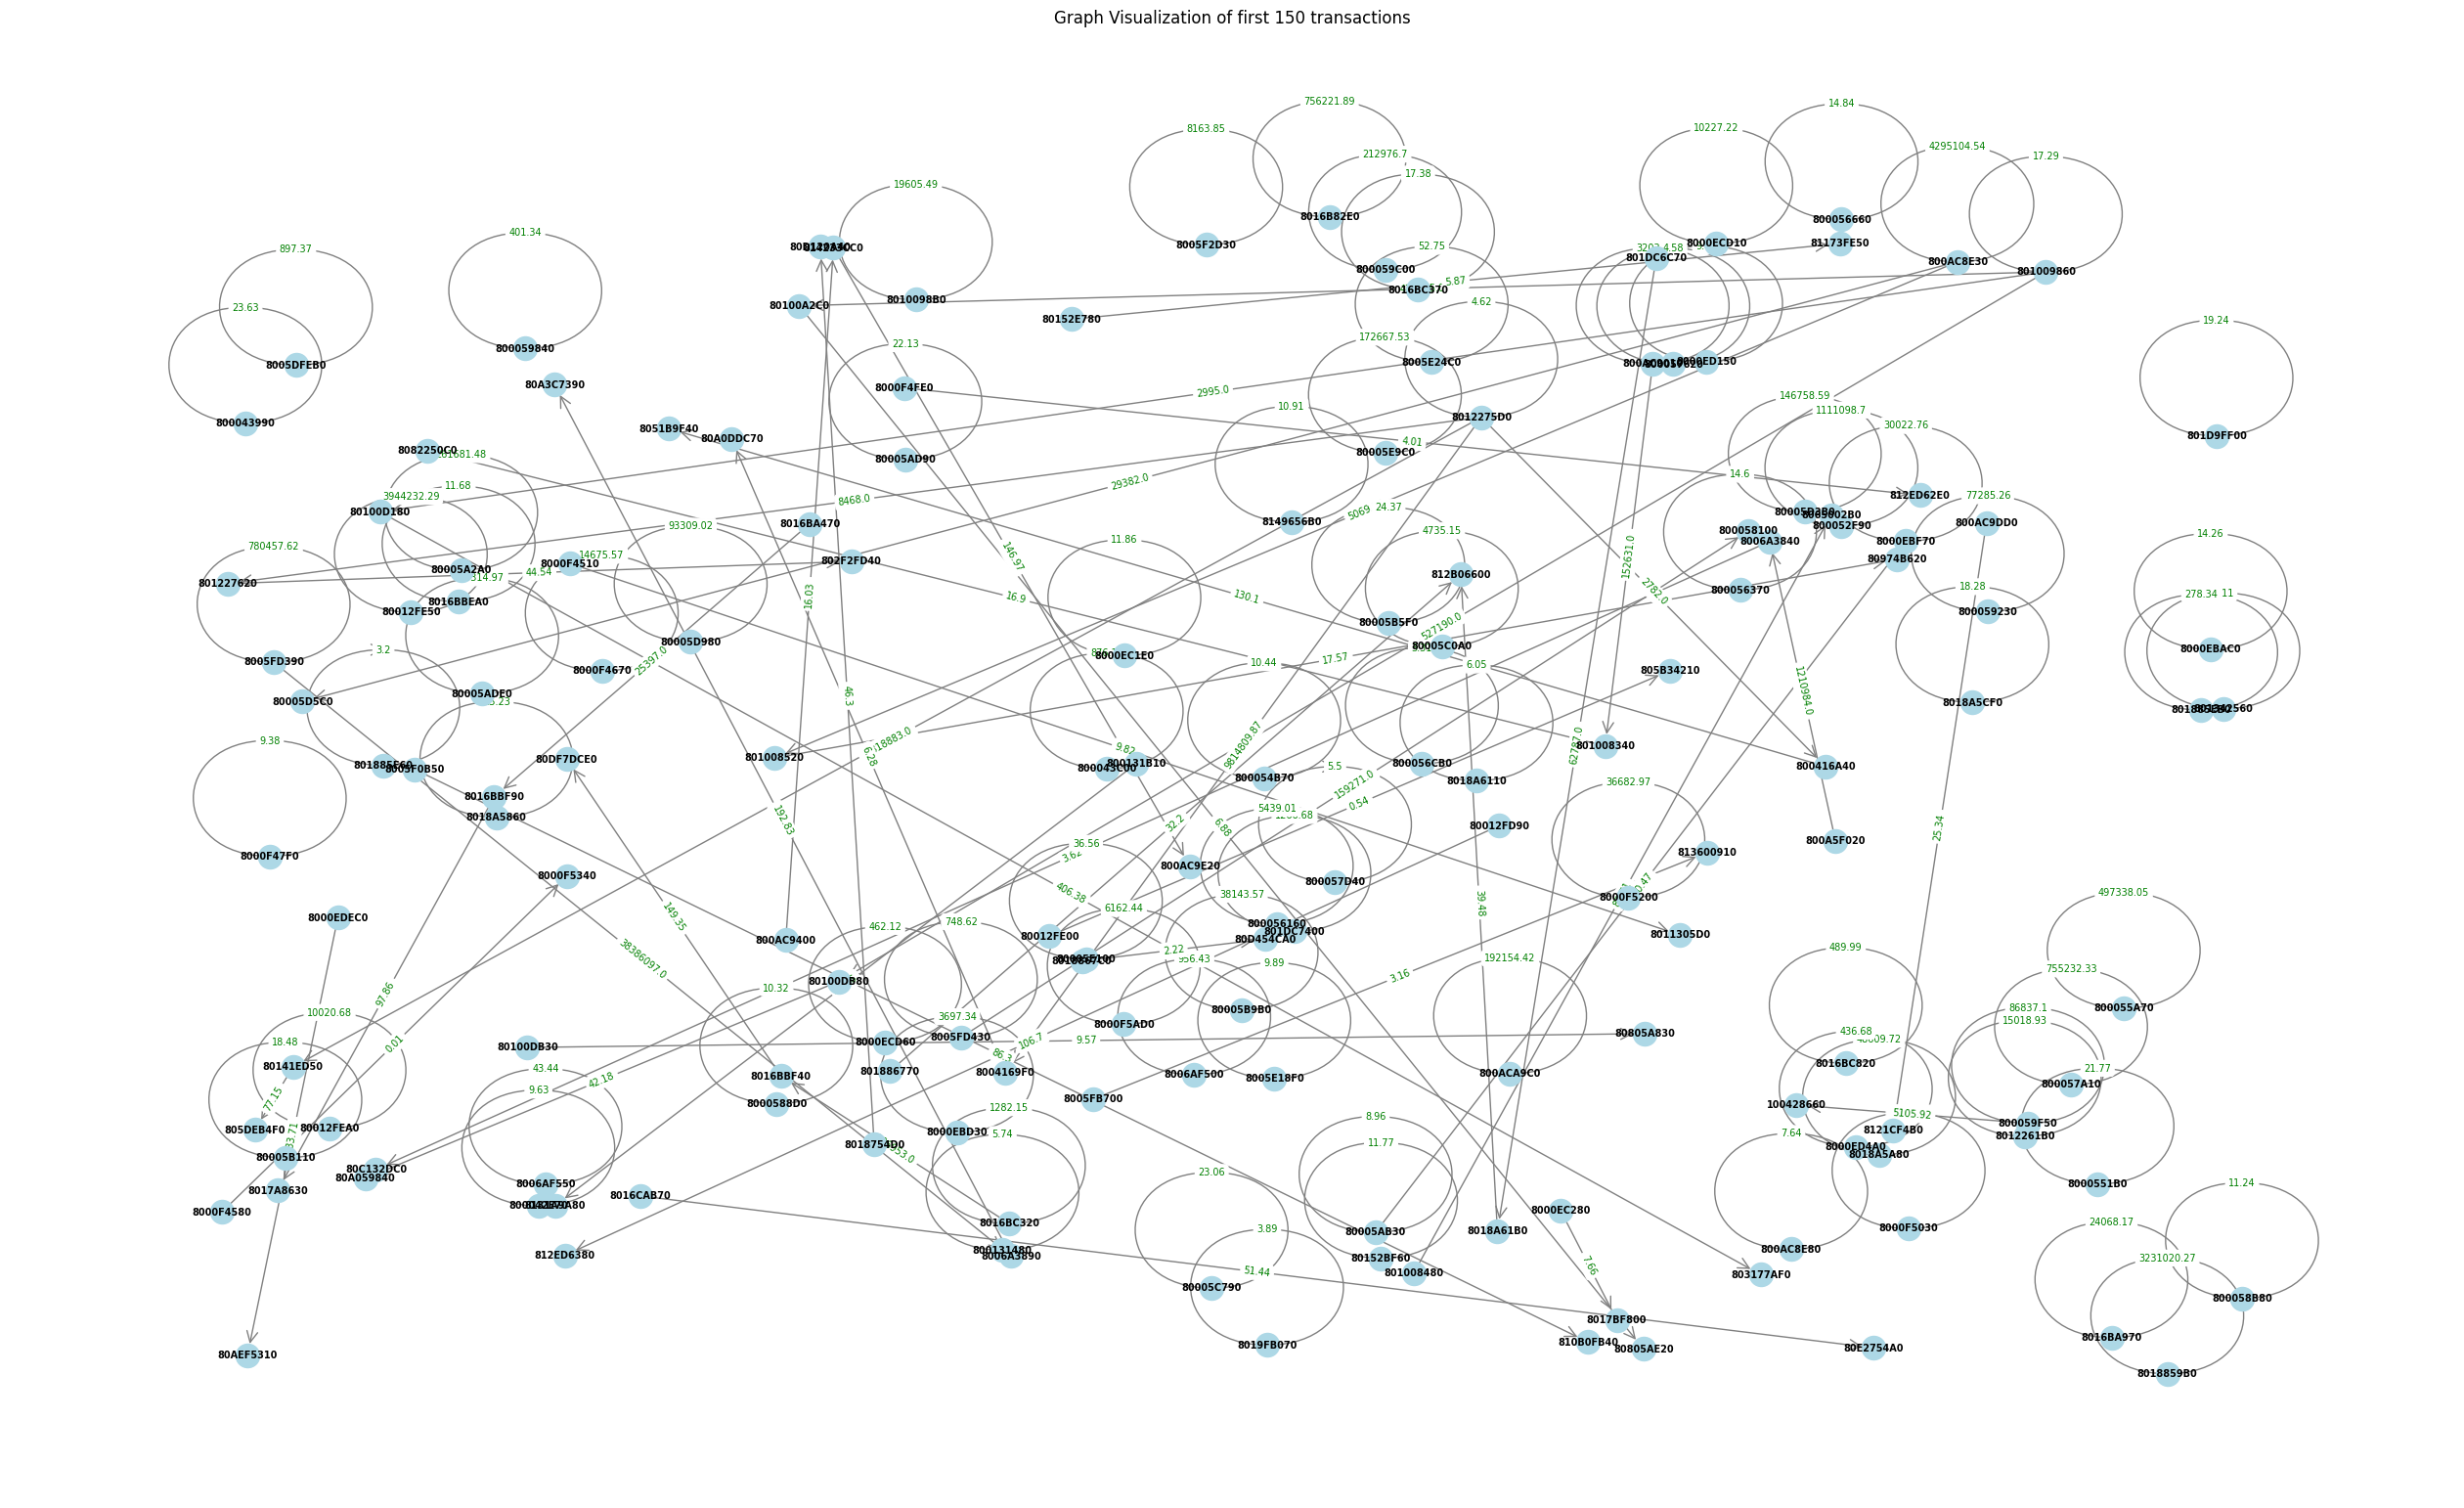

In [20]:
filename = '/Users/owhy/Documents/Datasets/HI-Small_Trans_3.csv'
# Create an instance of the AMLDataPreprocessing class
data_preprocessor = AMLDataPreprocessing(filename)
# Process the data
input_data, graph_full, x, y, labels, links, edges_amount, node_features, edges_features = data_preprocessor.process_data()
# Visualize
visual = data_preprocessor.visualize_graph(links, edges_amount)
adjacency_matrix = torch.from_numpy(nx.adjacency_matrix(graph_full).todense()).to(torch.float)

## Save the data

In [21]:
import pickle

with open("graph.pickle", "wb") as f:
    pickle.dump({
        'edges_features': edges_features,
        'links': links,
        'labels': labels,
        'graph_full': graph_full,
        'adjacency_matrix': adjacency_matrix,
        'visual': visual,
        'node_features': node_features,
        'x': x,
        'y': y,
        'labels': labels,
        'input_data': input_data
    }, f)


# GRAPH NEURAL NETWORKS

In [22]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, NNConv
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import MessagePassing


In [23]:
input_data.edge_attr.size()

torch.Size([4999, 26])

In [24]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GNNLayer(MessagePassing):
    def __init__(self, node_features, edge_features, hidden_channels):
        super(GNNLayer, self).__init__(aggr='add')
        
        self.node_features = node_features
        self.edge_features = edge_features
        self.hidden_channels = hidden_channels
        
        # Learnable parameters
        self.weight_node = nn.Parameter(torch.Tensor(node_features, hidden_channels))
        self.weight_edge = nn.Parameter(torch.Tensor(edge_features, hidden_channels))
        
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight_node)
        nn.init.xavier_uniform_(self.weight_edge)
        
    def forward(self, x, edge_index, edge_attr):
        # AXW0 + EW1
        global adjacency_matrix
        self.adjacency_matrix = adjacency_matrix
        # adj_matrix = torch.zeros((x.size(0), x.size(0)), device=x.device)
        # adj_matrix[edge_index[0], edge_index[1]] = 1  # Assuming edge_index is of shape (2, num_edges)

        axw = torch.matmul(self.adjacency_matrix, x) @ self.weight_node
        ew = torch.matmul(edge_attr, self.weight_edge)

        # print("-----------------")
        # print(x.size())
        # print(self.adjacency_matrix.size())
        # print(self.weight_node.size())
        # print(edge_attr.size())
        # print(self.weight_edge.size())
        
        # print(axw.size())
        # print(ew.size())

        return axw, ew

    def update(self, aggr_out):
        return aggr_out
    
class GNNModel(nn.Module):
    def __init__(self, node_features, edge_features, hidden_channels, out_channels):
        super(GNNModel, self).__init__()

        self.conv1 = GNNLayer(node_features, edge_features, hidden_channels)
        self.conv2 = GNNLayer(hidden_channels, hidden_channels, 128)
        self.conv3 = GNNLayer(128, 128, 256)
        self.conv4 = GNNLayer(256, 256, 128)
        self.conv5 = GNNLayer(128, 128, hidden_channels)
        self.conv6 = GNNLayer(hidden_channels, hidden_channels, out_channels)

        # Decoder for node features
        self.decoder_x = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, node_features)
        )

        # Decoder for edge features
        self.decoder_e = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, edge_features)
        )

        self.relu = nn.ReLU()

    def forward(self, x, edge_index, edge_attr):
        # Two GNN layers with ReLU activation in between.
        axw1, ew1 = self.conv1(x, edge_index, edge_attr)
        edge_attr = self.update_edge_attr(edge_attr, self.conv1.hidden_channels)
        axw2, ew2 = self.conv2(self.relu(axw1), edge_index, edge_attr)
        edge_attr = self.update_edge_attr(edge_attr, self.conv2.hidden_channels)
        axw3, ew3 = self.conv3(self.relu(axw2), edge_index, edge_attr)
        edge_attr = self.update_edge_attr(edge_attr, self.conv3.hidden_channels)
        axw4, ew4 = self.conv4(self.relu(axw3), edge_index, edge_attr)
        edge_attr = self.update_edge_attr(edge_attr, self.conv4.hidden_channels)
        axw5, ew5 = self.conv5(self.relu(axw4), edge_index, edge_attr)
        edge_attr = self.update_edge_attr(edge_attr, self.conv5.hidden_channels)
        axw6, ew6 = self.conv6(self.relu(axw5), edge_index, edge_attr)
        edge_attr = self.update_edge_attr(edge_attr, self.conv6.hidden_channels)
        
        return axw6, ew6 # returning x and e embeddings

    def update_edge_attr(self, edge_attr, new_channels):
        # Update edge attributes to have 'new_channels'
        # Assuming edge_attr is a tensor of shape (num_edges, num_edge_features)
        num_edge_features = edge_attr.size(1)
        
        if new_channels > num_edge_features:
            # Pad with zeros to match new_channels
            updated_edge_attr = torch.cat((edge_attr, torch.zeros((edge_attr.size(0), new_channels - num_edge_features), device=edge_attr.device)), dim=1)
        else:
            # Keep only the first new_channels channels
            updated_edge_attr = edge_attr[:, :new_channels]
        
        return updated_edge_attr

In [25]:
from torch_geometric.loader import DataLoader

learning_rate = 0.01
hidden_channels = 64
out_channels = 15

model = GNNModel(node_features=input_data.x.size(1), edge_features=input_data.edge_attr.size(1), hidden_channels=hidden_channels, out_channels=out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss

def train(data): # using reconstruction loss
    model.train()
    optimizer.zero_grad()
    x_embedding, e_embedding = model(input_data.x, input_data.edge_index, input_data.edge_attr)
    
    # Reconstruction loss using MSE
    reconstruction_loss = nn.MSELoss()
    reconstructed_x = model.decoder_x(x_embedding)  # Assuming you have a decoder for x
    reconstructed_e = model.decoder_e(e_embedding)  # Assuming you have a decoder for e
    loss_x = reconstruction_loss(reconstructed_x, input_data.x)
    loss_e = reconstruction_loss(reconstructed_e, input_data.edge_attr)
    
    # Total loss
    loss = loss_x + loss_e
    
    loss.backward()
    optimizer.step()
    
    return loss.item(), x_embedding, e_embedding

In [26]:
# Continue training loop from provided script
epochs = 600
losses = []

all_x_embeddings = []
all_e_embeddings = []

for epoch in range(epochs):
    loss, x_embedding, e_embedding = train(input_data)
    losses.append(loss)
    all_x_embeddings.append(x_embedding.detach().cpu().numpy())
    all_e_embeddings.append(e_embedding.detach().cpu().numpy())
    print(f'Epoch {epoch}, Total Loss: {loss}')


Epoch 0, Total Loss: 22578.224609375
Epoch 1, Total Loss: 64500.8984375
Epoch 2, Total Loss: 16696.232421875
Epoch 3, Total Loss: 2035.0975341796875
Epoch 4, Total Loss: 1017.4956665039062
Epoch 5, Total Loss: 463.4000244140625
Epoch 6, Total Loss: 278.8720703125
Epoch 7, Total Loss: 336.07135009765625
Epoch 8, Total Loss: 119.38766479492188
Epoch 9, Total Loss: 97.86336517333984
Epoch 10, Total Loss: 142.1699981689453
Epoch 11, Total Loss: 157.519287109375
Epoch 12, Total Loss: 159.60411071777344
Epoch 13, Total Loss: 139.81060791015625
Epoch 14, Total Loss: 81.68769836425781
Epoch 15, Total Loss: 35.35710525512695
Epoch 16, Total Loss: 85.9158935546875
Epoch 17, Total Loss: 19.998870849609375
Epoch 18, Total Loss: 50.39647674560547
Epoch 19, Total Loss: 44.42939758300781
Epoch 20, Total Loss: 54.22086715698242
Epoch 21, Total Loss: 51.3678092956543
Epoch 22, Total Loss: 47.56150817871094
Epoch 23, Total Loss: 42.070220947265625
Epoch 24, Total Loss: 35.15662384033203
Epoch 25, Total 

In [27]:
import gzip
import torch

def save_embeddings_as_triples(edge_index, node_embeddings, edge_embeddings, file_path):
    with gzip.open(file_path, 'wt') as f:
        for i in range(edge_index.size(1)):
            head_index = edge_index[0, i].item()
            tail_index = edge_index[1, i].item()
            head_uri = f"http://example.org/node/{head_index}"
            tail_uri = f"http://example.org/node/{tail_index}"
            relation_uri = f"http://example.org/relation/{i}"

            # Write connectedTo triple
            f.write(f'<{head_uri}> <http://example.org/ontology#connectedTo> <{tail_uri}>\n')
            
            # Write head node embedding triple
            head_embedding = node_embeddings[head_index].numpy()
            head_str = ' '.join(map(str, head_embedding))
            f.write(f'<{head_uri}> <http://example.org/ontology#hasEmbedding> "{head_str}"\n')
            
            # Write tail node embedding triple
            tail_embedding = node_embeddings[tail_index].numpy()
            tail_str = ' '.join(map(str, tail_embedding))
            f.write(f'<{tail_uri}> <http://example.org/ontology#hasEmbedding> "{tail_str}"\n')
            
            # Write edge embedding triple
            relation_embedding = edge_embeddings[i].numpy()
            relation_str = ' '.join(map(str, relation_embedding))
            f.write(f'<{relation_uri}> <http://example.org/ontology#hasEmbedding> "{relation_str}"\n')

# Example usage after training
x_embeddings = torch.tensor(all_x_embeddings[-1])  # Use the last epoch's embeddings
e_embeddings = torch.tensor(all_e_embeddings[-1])  # Use the last epoch's embeddings

save_embeddings_as_triples(input_data.edge_index, x_embeddings, e_embeddings, 'embeddings.nt.gz')


In [28]:
import gzip

def print_rdf_triples(file_path):
    # counter = 0
    with gzip.open(file_path, 'rt') as f:
        counter = 0
        for line in f:
            print(line.strip())
            counter += 1
    print(counter)

# Replace 'embeddings.nt.gz' with the actual file path
print_rdf_triples("embeddings.nt.gz") # CONNECTED TO --> HAS EMBEDDING
# print(4999*4)

<http://example.org/node/0> <http://example.org/ontology#connectedTo> <http://example.org/node/0> .
<http://example.org/node/0> <http://example.org/ontology#hasEmbedding> "-0.017987879 0.035605993 0.015844865 -0.026895138 -0.012528165 -0.018955987 -0.013677435 0.004657217 0.0022780087 0.0383246 -0.035561215 -0.022686224 0.010606004 -0.032880012 0.013346648" .
<http://example.org/node/0> <http://example.org/ontology#hasEmbedding> "-0.017987879 0.035605993 0.015844865 -0.026895138 -0.012528165 -0.018955987 -0.013677435 0.004657217 0.0022780087 0.0383246 -0.035561215 -0.022686224 0.010606004 -0.032880012 0.013346648" .
<http://example.org/relation/0> <http://example.org/ontology#hasEmbedding> "-19.251066 -19.480663 46.630272 15.628145 -23.920092 44.332394 15.1349125 27.477798 20.385468 -29.92798 57.302643 26.967865 54.983856 -23.950922 10.878825" .
<http://example.org/node/1> <http://example.org/ontology#connectedTo> <http://example.org/node/3734> .
<http://example.org/node/1> <http://exa

In [29]:
def evaluate_reconstruction(x_embeddings, e_embeddings, model, input_data):
    model.eval()
    reconstructed_x = model.decoder_x(torch.tensor(x_embeddings).to(input_data.x.device))
    reconstructed_e = model.decoder_e(torch.tensor(e_embeddings).to(input_data.edge_attr.device))
    
    mse_loss = nn.MSELoss()
    loss_x = mse_loss(reconstructed_x, input_data.x)
    loss_e = mse_loss(reconstructed_e, input_data.edge_attr)
    
    return loss_x.item(), loss_e.item()

loss_x, loss_e = evaluate_reconstruction(all_x_embeddings[-1], all_e_embeddings[-1], model, input_data)
print(f'Reconstruction Loss for Node Features: {loss_x}')
print(f'Reconstruction Loss for Edge Features: {loss_e}')

Reconstruction Loss for Node Features: 0.12057965248823166
Reconstruction Loss for Edge Features: 0.14413435757160187


In [30]:
with open("embeddings.pickle", "wb") as f:
    pickle.dump({
        'x_embeddings': x_embeddings,
        'e_embeddings': e_embeddings
    }, f)